Cargamos las librerias

In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

# Modelos
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Metricas de evaluacion
from sklearn.metrics import silhouette_score, davies_bouldin_score, pairwise_distances

np.random.seed(16)

Cargamos el dataset de rfm preprocesado anteriormente

In [41]:
# Cargamos el dataset de rfm previamente filtrado con order_id, purchase_date y payment_value
df_rfm = pd.read_csv("df_rfm.csv")
df_rfm

customer_unique_id  \
0         c3f52311e0d977b3a47d494f5302414d   
1       "901900247abbb5f85dcc50827e81ab04"   
2       "3df11e3b6c22394922f7918cb3f0e406"   
3       "036720aaa0ccc7d3c63a5d7e5729b6e8"   
4         ce5d073fa3e86d122735100c7cda589e   
...                                    ...   
113364    b2a8277624dd3a5048145024016f980f   
113365  "0f0470ca2b9c77d9fed0c4e9137af190"   
113366  "332d18ef239d76af987e26132e73d7ad"   
113367  "024676cef113f6c81db6c5b8d29e5ee9"   
113368    bc6fcf73e35d6d0e147d7f2f72d9a89b   

                                  order_id        purchase_date  payment_value  
0       "4e10aee446b5dd3802f8c8e058581d2f"  2017-05-17 18:24:42          21.76  
1       "6196e4f322b4f0af89d0900e2990dab8"  2017-07-05 18:40:52          57.77  
2       "5e57d61ff3a5b4ce52915cdeb62b2571"  2017-11-08 19:30:03          37.77  
3         d2e81202cca4ca39792d6ec435a4bfcf  2017-10-14 15:13:03          29.77  
4       "77d2c1762d483a6012d9f32c2a59e5df"  2017-05-16 14:24:26          34.77  
...                                    ...                  ...            ...  
113364  "678563117c6bcedcb0f9d98e8f3faf23"  2017-05-17 17:13:08          23.50  
113365  "70009c6d985dfa16754461cff33c10dc"  2017-08-11 22:31:37         158.79  
113366  "32f1eaf64e65f64c1f57ef1612431740"  2017-11-25 00:25:18          65.15  
113367  "1d9a9731b9c10fc9cba74e6f74782e8b"  2018-05-01 14:30:35           3.17  
113368  "6d47bd16bfe3f754b853be0ba635ed7d"  2018-06-18 16:45:05          18.18  

[113369 rows x 4 columns]

Ingreso nuevo cliente a la base de datos

In [45]:
# Crear listas vacías para almacenar los datos de entradas
ids = []
order_ids = []
pay_vals = []
pur_dates = []

# Definimos el numero de clientes a ingresar por un input
num_records = int(input("¿Cuántos registros deseas ingresar? "))

# Recoger los datos del usuario
for num in range(num_records):
    customer_unique_id = str(input("Ingrese el ID del cliente: "))
    order_id = str(input("Ingrese el ID de la orden: "))
    payment_value = float(
        input("Ingrese el valor total de la orden con decimales: "))
    purchase_date = input(
        "Ingrese la fecha de compra en este formato '2018-06-18 16:45:05' sin comillas : ")

    # Añadir los datos a las listas
    ids.append(customer_unique_id)
    order_ids.append(order_id)
    pay_vals.append(payment_value)
    pur_dates.append(purchase_date)

# Visualizamos los nuevos registros
print("Informacion nuevos clientes")
print(f"id cliente: ")
for elemento in ids, order_ids, pay_vals, pur_dates:
    print(elemento)

In [47]:
# Creamos el df del nuevo cliente que será concatenado como una nueva fila al dataframe rfm
data = ({"customer_unique_id": ids, "order_id": order_ids,
        "purchase_date": pur_dates, "payment_value": pay_vals})

new_row = pd.DataFrame(data)
new_row["purchase_date"] = pd.to_datetime(new_row["purchase_date"])
new_row

customer_unique_id order_id       purchase_date  payment_value
0            aaaaaaa  bbbbbbb 2018-06-18 16:45:05           50.0

In [48]:
# Concatenamos
df_rfm = pd.concat([df_rfm, new_row], ignore_index=True)
df_rfm

customer_unique_id  \
0         c3f52311e0d977b3a47d494f5302414d   
1       "901900247abbb5f85dcc50827e81ab04"   
2       "3df11e3b6c22394922f7918cb3f0e406"   
3       "036720aaa0ccc7d3c63a5d7e5729b6e8"   
4         ce5d073fa3e86d122735100c7cda589e   
...                                    ...   
113365  "0f0470ca2b9c77d9fed0c4e9137af190"   
113366  "332d18ef239d76af987e26132e73d7ad"   
113367  "024676cef113f6c81db6c5b8d29e5ee9"   
113368    bc6fcf73e35d6d0e147d7f2f72d9a89b   
113369                             aaaaaaa   

                                  order_id        purchase_date  payment_value  
0       "4e10aee446b5dd3802f8c8e058581d2f"  2017-05-17 18:24:42          21.76  
1       "6196e4f322b4f0af89d0900e2990dab8"  2017-07-05 18:40:52          57.77  
2       "5e57d61ff3a5b4ce52915cdeb62b2571"  2017-11-08 19:30:03          37.77  
3         d2e81202cca4ca39792d6ec435a4bfcf  2017-10-14 15:13:03          29.77  
4       "77d2c1762d483a6012d9f32c2a59e5df"  2017-05-16 14:24:26          34.77  
...                                    ...                  ...            ...  
113365  "70009c6d985dfa16754461cff33c10dc"  2017-08-11 22:31:37         158.79  
113366  "32f1eaf64e65f64c1f57ef1612431740"  2017-11-25 00:25:18          65.15  
113367  "1d9a9731b9c10fc9cba74e6f74782e8b"  2018-05-01 14:30:35           3.17  
113368  "6d47bd16bfe3f754b853be0ba635ed7d"  2018-06-18 16:45:05          18.18  
113369                             bbbbbbb  2018-06-18 16:45:05          50.00  

[113370 rows x 4 columns]

Creacion df rfm

In [52]:
# Calculamos la fecha máxima del dataset, la que consideraremos para contrastarla contra las demas fechas y calcular recencia
df_rfm["purchase_date"] = pd.to_datetime(df_rfm["purchase_date"])
max_date = df_rfm["purchase_date"].max()

# Creamos las variables Recency (R), Frequency (F), Monetary (M)
df_rfm["dif_days"] = max_date - df_rfm["purchase_date"]
df_rfm["recency"] = df_rfm["dif_days"].dt.days


# Hacemos el groupby
by_rfm = df_rfm.groupby(by="customer_unique_id").agg({"recency": "max",
                                                      "order_id": "count",
                                                      "payment_value": "sum"

                                                      })
by_rfm

# Renombramos
by_rfm.columns = ["recency", "frequency", "monetary"]
by_rfm

recency  frequency  monetary
customer_unique_id                                              
"0000366f3b9a7992bf8c76cfdf3221e2"      111          1    141.90
"0000b849f77a49e4a4ce2b2a4ca5be3f"      114          1     27.19
"0000f46a3911fa3c0805444483337064"      536          1     86.22
"0000f6ccb0745a6a4b88665a16c9f078"      320          1     43.62
"0004aac84e0df4da2b147fca70cf8255"      287          1    196.89
...                                     ...        ...       ...
fffcf5a5ff07b0908bd4e2dbc735a684        446          2   4134.84
fffea47cd6d3cc0a88bd621562a9d061        261          1     84.58
ffff371b4d645b6ecea244b27531430a        567          1    112.46
ffff5962728ec6157033ef9805bacc48        118          1    133.69
ffffd2657e2aad2907e67c3e9daecbeb        483          1     71.56

[92065 rows x 3 columns]

Limpieza de outliers

In [147]:
# Limpiamos el 5 % de los outliers solo de recencia y monetary, ya que la mayor cantidad de valores en frequency es 1 y no aplica limpiarlos. Con mayor limpieza se pierden clientes valiosos
cols_to_clean = ["recency", "monetary"]


def clean_out(df, cols):
    df_clean = df.copy()

    for column in cols:
        Q1 = np.quantile(df[column], 0.05)
        Q3 = np.quantile(df[column], 0.95)
        IQR = Q3-Q1
        LOWER = (Q1 - 1.5 * IQR)
        UPPER = (Q3 + 1.5 * IQR)

        df_clean = df_clean[(df_clean[column] >= LOWER) &
                            (df_clean[column] <= UPPER)]
    return df_clean


rfm_clean = clean_out(by_rfm, cols_to_clean)

old_shape = by_rfm.shape[0]
new_shape = rfm_clean.shape[0]
print(
    f"Luego de la limpieza de outliers el dataset pasó de {old_shape} registros a tener {new_shape} registros")

Luego de la limpieza de outliers el dataset pasó de 92065 registros a tener 91057 registros


In [148]:
rfm_clean

recency  frequency  monetary
customer_unique_id                                              
"0000366f3b9a7992bf8c76cfdf3221e2"      111          1    141.90
"0000b849f77a49e4a4ce2b2a4ca5be3f"      114          1     27.19
"0000f46a3911fa3c0805444483337064"      536          1     86.22
"0000f6ccb0745a6a4b88665a16c9f078"      320          1     43.62
"0004aac84e0df4da2b147fca70cf8255"      287          1    196.89
...                                     ...        ...       ...
fffb09418989a0dbff854a28163e47c6        254          1     73.16
fffea47cd6d3cc0a88bd621562a9d061        261          1     84.58
ffff371b4d645b6ecea244b27531430a        567          1    112.46
ffff5962728ec6157033ef9805bacc48        118          1    133.69
ffffd2657e2aad2907e67c3e9daecbeb        483          1     71.56

[91057 rows x 3 columns]

Transformación logaritmica

In [109]:
# La aplicaremos a frequency y monetary por el sesgo que presentan en su distribución, para que no afecten en extremo al modelo
# rfm_clean["frequency"] = np.log(rfm_clean["frequency"] + 1) #Se añade un 1 para no generar log0
# rfm_clean["monetary"] = np.log(rfm_clean["monetary"] + 1) #Se añade un 1 para no generar log0

Estandarizacion de variables

In [149]:
# Instanciamos el scaler
scaler = StandardScaler()

X = pd.DataFrame(scaler.fit_transform(rfm_clean))
X.columns = rfm_clean.columns
X.index = rfm_clean.index
X

recency  frequency  monetary
customer_unique_id                                               
"0000366f3b9a7992bf8c76cfdf3221e2" -0.835288  -0.284536 -0.170254
"0000b849f77a49e4a4ce2b2a4ca5be3f" -0.815686  -0.284536 -0.736076
"0000f46a3911fa3c0805444483337064"  1.941631  -0.284536 -0.444903
"0000f6ccb0745a6a4b88665a16c9f078"  0.530303  -0.284536 -0.655033
"0004aac84e0df4da2b147fca70cf8255"  0.314683  -0.284536  0.100991
...                                      ...        ...       ...
fffb09418989a0dbff854a28163e47c6    0.099064  -0.284536 -0.509323
fffea47cd6d3cc0a88bd621562a9d061    0.144801  -0.284536 -0.452992
ffff371b4d645b6ecea244b27531430a    2.144183  -0.284536 -0.315471
ffff5962728ec6157033ef9805bacc48   -0.789550  -0.284536 -0.210751
ffffd2657e2aad2907e67c3e9daecbeb    1.595333  -0.284536 -0.517215

[91057 rows x 3 columns]

Visualizacion X

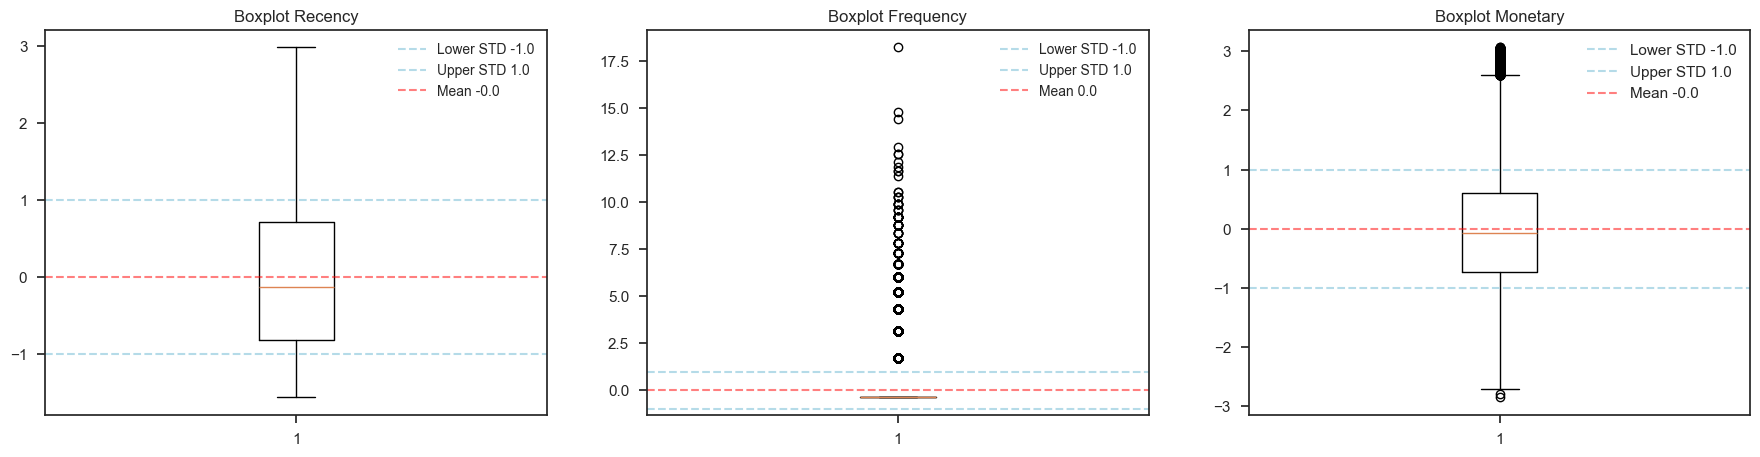

In [111]:
R = X["recency"]
F = X["frequency"]
M = X["monetary"]
sns.set_theme(style='ticks', palette='deep')
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(22, 5))
# Boxplots
axs[0].boxplot(R)
axs[0].set_title("Boxplot Recency")
axs[0].axhline(R.mean()-R.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Lower STD {round(R.mean()-R.std(),2)}")
axs[0].axhline(R.mean()+R.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Upper STD {round(R.mean()+R.std(),2)}")
axs[0].axhline(R.mean(), linestyle="dashed", color="red",


               alpha=0.5, label=f"Mean {round(R.mean(),1)}")
axs[0].legend(fontsize="small")
axs[1].boxplot(F)
axs[1].set_title("Boxplot Frequency")
axs[1].axhline(F.mean()-F.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Lower STD {round(F.mean()-F.std(),2)}")
axs[1].axhline(F.mean()+F.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Upper STD {round(F.mean()+F.std(),2)}")
axs[1].axhline(F.mean(), linestyle="dashed", color="red",
               alpha=0.5, label=f"Mean {round(F.mean(),1)}")
axs[1].legend(fontsize="small")

axs[2].boxplot(M)
axs[2].set_title("Boxplot Monetary")
axs[2].axhline(M.mean()-M.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Lower STD {round(M.mean()-M.std(),2)}")
axs[2].axhline(M.mean()+M.std(), linestyle="dashed", color="lightblue",
               alpha=0.9, label=f"Upper STD {round(M.mean()+M.std(),2)}")
axs[2].axhline(M.mean(), linestyle="dashed", color="red",
               alpha=0.5, label=f"Mean {round(M.mean(),2)}")
axs[2].legend()
plt.legend()

Clustering

Elbow Method

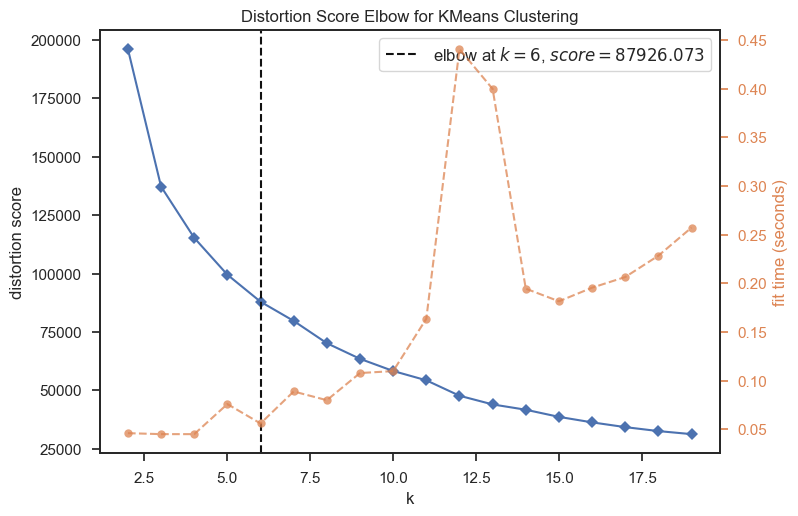

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [150]:
kmeans = KMeans(random_state=16)
elbow = KElbowVisualizer(kmeans, k=(2, 20))
elbow.fit(X)
elbow.show()

In [151]:
kmeans_opt = KMeans(n_clusters=elbow.elbow_value_, random_state=16).fit(X)
# Guardamos el resultado del clustering en una columna
X["cluster"] = kmeans_opt.labels_

# Hacemos una pequeña revision de resultados
X.groupby(["cluster"]).mean()

# Evaluamos
sil_coef = silhouette_score(X, kmeans_opt.labels_)
dav_coef = davies_bouldin_score(X, kmeans_opt.labels_)

print("Silhouette Score:", sil_coef)
print("Davies-Bouldin Index:", dav_coef)

Silhouette Score: 0.6405627902632358
Davies-Bouldin Index: 0.7517476368912792


In [152]:
# Aplicamos el resultado al df sin normalizar para interpretar de mejor manera los clusters
rfm_clean = clean_out(by_rfm, cols_to_clean)
rfm_clean["cluster"] = kmeans_opt.labels_
# Visualizamos algunas metricas de los cluster
rfm_clean.groupby(["cluster"]).mean()

recency  frequency    monetary
cluster                                   
0        141.908272   1.000226  118.233792
1        266.811522   4.217909  795.576425
2        413.868721   1.055446  124.833368
3        235.452001   1.319917  785.232073
4        212.687036   2.178618  252.527062
5        302.583333  21.250000  423.818333

In [138]:
# Podemos ver directamente el cluster del nuevo cliente ingresado
customers = index

X.query("customer_unique_id == '@aaaaaaa'")

recency  frequency  monetary  cluster
customer_unique_id                                        
aaaaaaa            -1.096645      -0.37 -0.996341        2

Visualizacion clustering

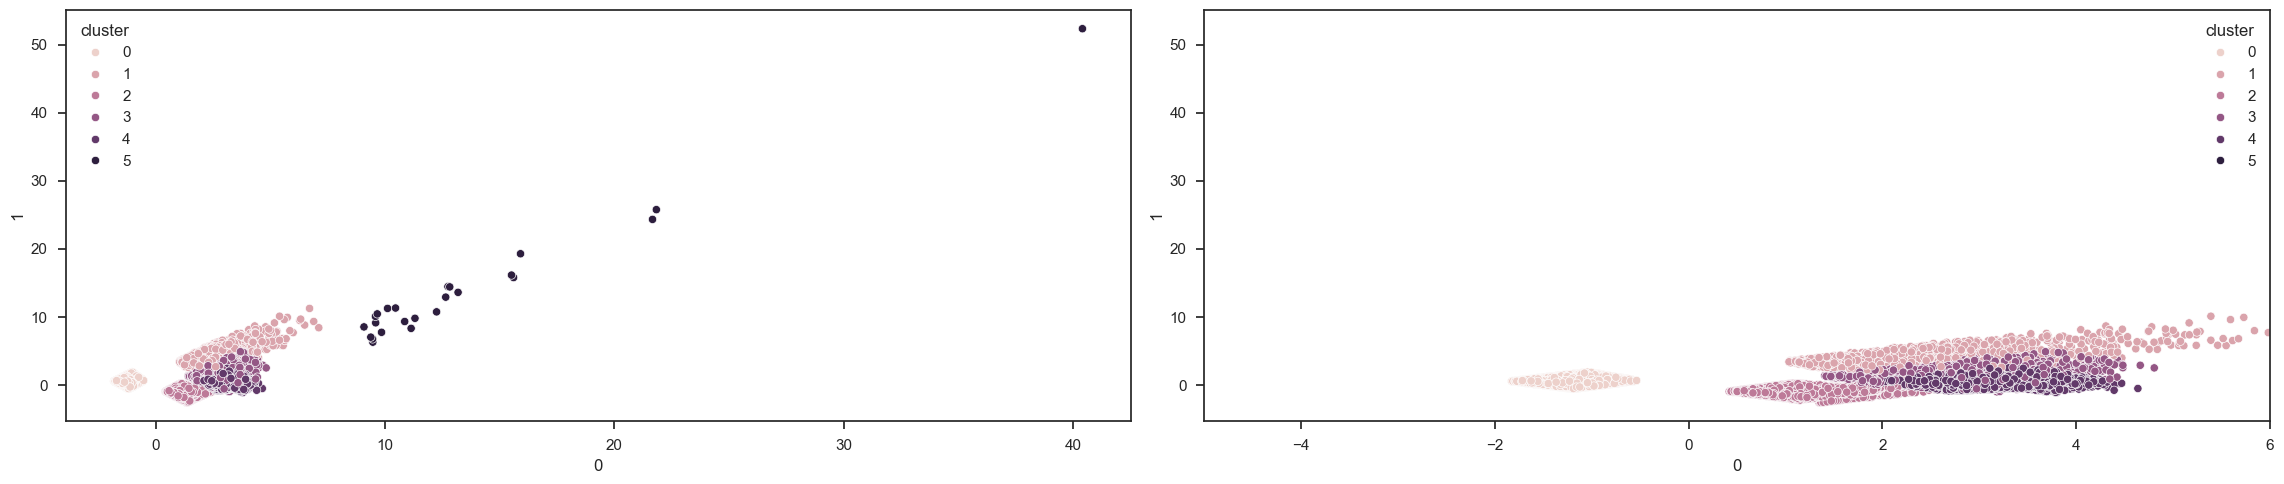

In [156]:
pca = PCA(n_components=2)
df_to_plot = pd.DataFrame(pca.fit_transform(X))
df_to_plot["cluster"] = kmeans_opt.labels_

fig, axs = plt.subplots(1, 2, figsize=(23, 5))
sns.scatterplot(data=df_to_plot, x=0, y=1, hue="cluster", ax=axs[0])

sns.scatterplot(data=df_to_plot, x=0, y=1, hue="cluster", ax=axs[1])
axs[1].set_xlim(-5, 6)

plt.tight_layout()
plt.show()

In [158]:
# Creamos una visualizacion 3D de la segmentacion
rfm_clean["cluster"] = rfm_clean["cluster"].astype(str)

# Creamos el grafico
fig = px.scatter_3d(rfm_clean, x="recency", y="frequency", z="monetary",
                    color="cluster", opacity=0.2)

# Configuramos el tamaño de los markers
fig.update_traces(marker_size=5)
fig.show()

Recomendaciones según Cluster cliente